In [1]:
import transformers # version 4.0.0
from transformers import BertModel, BertTokenizer

import torch # version 1.7.0
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F

import numpy as np # version 1.19.2
import pandas as pd # version 1.1.3
import seaborn as sns # version 0.11.0
import matplotlib.pyplot as plt # version 3.3.2
import time

from sklearn.model_selection import train_test_split # version
from sklearn.metrics import mean_squared_error, mean_absolute_error

from collections import defaultdict

In [2]:
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda', index=0)

# Read data

In [4]:
df = pd.read_csv('Hotel_Reviews.csv')

In [5]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [6]:
df.shape

(515738, 17)

C:\Users\michi\anaconda3\envs\annelies-pytorch-bert\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


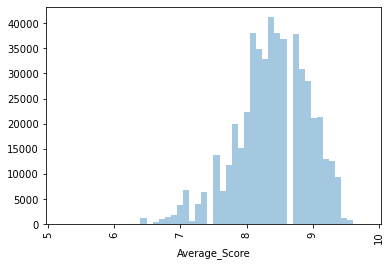

In [7]:
sns.distplot(df['Average_Score'], kde=False)
plt.xticks(rotation='vertical')
plt.show()

In [8]:
df['Average_Score'].describe()

count    515738.000000
mean          8.397487
std           0.548048
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: Average_Score, dtype: float64

# Choosing max_length

In [9]:
df['Review_Total_Positive_Word_Counts'].describe()

count    515738.000000
mean         17.776458
std          21.804185
min           0.000000
25%           5.000000
50%          11.000000
75%          22.000000
max         395.000000
Name: Review_Total_Positive_Word_Counts, dtype: float64

In [10]:
(df['Review_Total_Negative_Word_Counts'] + df['Review_Total_Positive_Word_Counts']  < 150).mean()

0.9794624402312803

98% of datapoints have less than 150 words in the positive and negative review

In [11]:
MAX_LEN = 150

# Playing around with the tokenizer

In [12]:
PRE_TRAINED_MODEL_NAME = "bert-base-uncased"

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
sentence = "I hate this hotel so much. The sheets were very dirty, I couldn't sleep in them at all! I wish i never came."

In [15]:
tokens = tokenizer.tokenize(sentence)

In [16]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [17]:
for i in range(len(tokens)):
    print(tokens[i], token_ids[i])

i 1045
hate 5223
this 2023
hotel 3309
so 2061
much 2172
. 1012
the 1996
sheets 8697
were 2020
very 2200
dirty 6530
, 1010
i 1045
couldn 2481
' 1005
t 1056
sleep 3637
in 1999
them 2068
at 2012
all 2035
! 999
i 1045
wish 4299
i 1045
never 2196
came 2234
. 1012


In [18]:
encoding = tokenizer(sentence + ' [SEP] ' + sentence,
                     max_length=MAX_LEN,
                    return_tensors='pt',
                    padding='max_length',
                    truncation=True)

In [19]:
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [20]:
encoding['input_ids']

tensor([[ 101, 1045, 5223, 2023, 3309, 2061, 2172, 1012, 1996, 8697, 2020, 2200,
         6530, 1010, 1045, 2481, 1005, 1056, 3637, 1999, 2068, 2012, 2035,  999,
         1045, 4299, 1045, 2196, 2234, 1012,  102, 1045, 5223, 2023, 3309, 2061,
         2172, 1012, 1996, 8697, 2020, 2200, 6530, 1010, 1045, 2481, 1005, 1056,
         3637, 1999, 2068, 2012, 2035,  999, 1045, 4299, 1045, 2196, 2234, 1012,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  

In [21]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'i',
 'hate',
 'this',
 'hotel',
 'so',
 'much',
 '.',
 'the',
 'sheets',
 'were',
 'very',
 'dirty',
 ',',
 'i',
 'couldn',
 "'",
 't',
 'sleep',
 'in',
 'them',
 'at',
 'all',
 '!',
 'i',
 'wish',
 'i',
 'never',
 'came',
 '.',
 '[SEP]',
 'i',
 'hate',
 'this',
 'hotel',
 'so',
 'much',
 '.',
 'the',
 'sheets',
 'were',
 'very',
 'dirty',
 ',',
 'i',
 'couldn',
 "'",
 't',
 'sleep',
 'in',
 'them',
 'at',
 'all',
 '!',
 'i',
 'wish',
 'i',
 'never',
 'came',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]'

# Splitting train, validation and test set

In [22]:
class ReviewDataset(Dataset):
    def __init__(self, positive_reviews, negative_reviews, targets, tokenizer, max_len):
        self.positive_reviews = positive_reviews
        self.negative_reviews = negative_reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.positive_reviews)
    
    def __getitem__(self, item):
        positive_review = self.positive_reviews[item]
        negative_review = self.negative_reviews[item]
        review = ' '.join([positive_review, tokenizer.sep_token, negative_review])
        target = self.targets[item]
        
        encoding = self.tokenizer(review, 
                                  max_length=self.max_len,
                                  return_tensors='pt',
                                  padding='max_length',
                                  truncation=True)
        
        return {'positive_review': positive_review,
                'negative_review': negative_review,
               'input_ids': encoding['input_ids'].flatten(),
               'attention_masks': encoding['attention_mask'].flatten(),
               'targets': torch.tensor([target], dtype=torch.float32)}

In [23]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(464164, 17)
(25787, 17)
(25787, 17)


In [24]:
train_dataset = ReviewDataset(df_train['Positive_Review'].to_numpy(),
                              df_train['Negative_Review'].to_numpy(),
                              df_train['Average_Score'].to_numpy(), 
                              tokenizer, 
                              MAX_LEN)

In [25]:
train_dataset[0]

{'positive_review': ' Martin acoustic in room Local independent radio Cocktails Design Sister Ray ',
 'negative_review': ' All good ',
 'input_ids': tensor([  101,  3235,  6490,  1999,  2282,  2334,  2981,  2557, 18901,  2015,
          2640,  2905,  4097,   102,  2035,  2204,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     

# Create data loader

In [26]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = ReviewDataset(positive_reviews=df['Positive_Review'].to_numpy(), 
                            negative_reviews=df['Negative_Review'].to_numpy(), 
                            targets=df['Average_Score'].to_numpy(), 
                            tokenizer=tokenizer, 
                            max_len=max_len)
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [27]:
train_data_loader_small = create_data_loader(df_train.sample(2048), tokenizer, MAX_LEN, 8)
val_data_loader_small = create_data_loader(df_val.sample(1024), tokenizer, MAX_LEN, 8)
test_data_loader_small = create_data_loader(df_test.sample(1024), tokenizer, MAX_LEN, 8)

In [28]:
data = next(iter(train_data_loader_small))
data.keys()

dict_keys(['positive_review', 'negative_review', 'input_ids', 'attention_masks', 'targets'])

In [29]:
print(data['input_ids'].shape)
print(data['attention_masks'].shape)
print(data['targets'].shape)

torch.Size([8, 150])
torch.Size([8, 150])
torch.Size([8, 1])


# Playing around with Bert

In [30]:
def get_number_of_trainable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    number_of_trainable_params = sum([np.prod(p.size()) for p in model_parameters])
    return number_of_trainable_params

In [31]:
bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [32]:
get_number_of_trainable_parameters(bert)

109482240

In [33]:
# make bert non-trainable
for p in bert.parameters():
    p.requires_grad = False

In [34]:
get_number_of_trainable_parameters(bert)

0

In [35]:
last_hidden_state = bert(input_ids=encoding['input_ids'],
                         attention_mask=encoding['attention_mask']).last_hidden_state

In [36]:
last_hidden_state

tensor([[[ 0.1047,  0.1783,  0.2746,  ..., -0.2909,  0.4399,  0.4824],
         [ 0.1740,  0.2440, -0.0598,  ..., -0.2546,  0.8317,  0.4182],
         [ 0.0329,  0.6885,  0.5116,  ...,  0.3182,  0.4465,  0.0589],
         ...,
         [ 0.0616,  0.5523,  0.5076,  ...,  0.2245,  0.5645, -0.0099],
         [ 0.3699,  0.3882,  0.6122,  ...,  0.2463,  0.2398,  0.0868],
         [ 0.0317,  0.0147,  0.5177,  ...,  0.1229,  0.1233, -0.0636]]])

In [37]:
last_hidden_state.shape

torch.Size([1, 150, 768])

In [38]:
pooler_output = bert(input_ids=encoding['input_ids'],
                         attention_mask=encoding['attention_mask']).pooler_output

In [39]:
pooler_output.shape

torch.Size([1, 768])

In [40]:
bert.config.hidden_size

768

# Building the architecture of the model

In [41]:
class SentimentRegressor(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        for p in self.bert.parameters():
            p.requires_grad = False # bert parameters are non-trainable
        
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 1)
        
    def forward(self, input_ids, attention_mask):
        pooler_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        x = self.drop(pooler_output) # dropout
        output = self.out(x) # linear output layer
        return output

In [42]:
model = SentimentRegressor()
print(f'Number of trainable parameters: {get_number_of_trainable_parameters(model)}')

Number of trainable parameters: 769


In [43]:
model = model.to(device)

In [44]:
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
output = model(input_ids, attention_mask)
print(output.shape)
print(output)

torch.Size([1, 1])
tensor([[0.5176]], device='cuda:0', grad_fn=<AddmmBackward>)


# Train first batch

In [45]:
optimizer = Adam(model.parameters())

criterion = nn.MSELoss().to(device)

In [46]:
def train_batch(model, data, loss_criterion, optimizer, device):
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_masks'].to(device)
    targets = data['targets'].to(device)
    
    # zero the gradients
    optimizer.zero_grad()
      
    # forward pass
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # compute loss
    loss = loss_criterion(outputs, targets)
    
    # backward pass
    loss.backward()
    
    # optimise
    optimizer.step()
    
    return loss

In [47]:
train_batch(model, data, criterion, optimizer, device)

tensor(65.2578, device='cuda:0', grad_fn=<MseLossBackward>)

# Tune batch size
Smaller batch sizes are typically more accurate, but we don't want to wait a long time.
Try for different batch sizes how many rows per second are processed on the GPU. This should go up for larger batch sizes. We choose the smallest batch size where the speed levels off.

In [48]:
batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256]

times = {}

for batch_size in batch_sizes:
    try:
        print(f'batch size: {batch_size}')
        model = model.train()
        data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, batch_size)

        for i, data in enumerate(data_loader, 0):
            if i == 2: # allow for warming-up
                start_time = time.time()
            if i == 100:
                execution_time = time.time() - start_time
                times[batch_size] = execution_time
                print(f'execution time: {execution_time}')
                break
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            loss = train_batch(model, data, criterion, optimizer, device)
    except RuntimeError: # if it doesn't fit in memory, then we exclude that batch_size anyway
        print(f'RunTimeError for batch size {batch_size}')
        continue

batch size: 2
execution time: 2.945843458175659
batch size: 4
execution time: 5.333263158798218
batch size: 8
execution time: 9.868367671966553
batch size: 16
execution time: 18.358663320541382
batch size: 32
execution time: 36.37986445426941
batch size: 64
execution time: 75.68815088272095
batch size: 128
execution time: 158.13126730918884
batch size: 256
RunTimeError for batch size 256


In [49]:
times = pd.Series(times)

In [50]:
n_rows_processed = pd.Series(times.index * 98)
n_rows_processed.index = times.index

In [51]:
times / n_rows_processed # time needed to process 1 row for different batch sizes

2      0.015030
4      0.013605
8      0.012587
16     0.011708
32     0.011601
64     0.012068
128    0.012606
dtype: float64

We see that the time needed to process 1 row goes down when the batch size increases from 2 to 16 and then levels off. We will therefore choose a batch size of 16

In [52]:
BATCH_SIZE = 16

# Tune learning rate

In [53]:
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]

losses = {}

for lr in learning_rates:
    print('-' * 10)
    print(lr)
    
    data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    model = SentimentRegressor()
    model.to(device)
    optimizer = Adam(model.parameters(), lr)

    losses[lr] = []
    model = model.train()

    temp_losses = []
    for i, data in enumerate(data_loader, 0):
        if i == 300: # we do 200 batches
            break
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        loss = train_batch(model, data, criterion, optimizer, device)
        temp_losses.append(loss.item())
        
        if i % 10 == 9: 
            average_loss_last_10_batches = np.mean(temp_losses)
            temp_losses = []
            losses[lr].append(average_loss_last_10_batches)
            print(average_loss_last_10_batches)

----------
0.1
165.56466674804688
48.540056228637695
21.932776117324828
17.564841556549073
7.3965473651885985
8.21710388660431
4.553069925308227
4.176138913631439
3.277241051197052
3.5704981207847597
2.889894199371338
1.958656805753708
2.1598544001579283
2.0347837686538695
1.624094009399414
1.4740884006023407
1.4664286255836487
1.2996995449066162
1.5737771928310393
1.6578249990940095
0.9799456000328064
1.0445643454790114
1.0061921656131745
1.243844872713089
1.3935972094535827
1.3888797819614411
1.5929329633712768
1.102578204870224
0.920906126499176
1.5172939956188203
----------
0.01
21.165275430679323
5.828134536743164
1.7678585588932036
1.3630419969558716
0.9854787826538086
0.794315853714943
0.6379954218864441
0.6486513197422028
0.7574374586343765
0.735623013973236
0.6117254853248596
0.7581130862236023
0.6676876008510589
0.5858122855424881
0.4442417949438095
0.6452324837446213
0.6977662891149521
0.687086546421051
0.5829730987548828
0.7581661164760589
0.6847238063812255
0.5635361164808

In [54]:
learning_curves = pd.DataFrame(losses)
learning_curves.index = learning_curves.index * 10 + 10

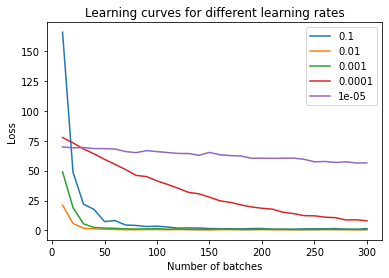

In [55]:
learning_curves.plot()
plt.title('Learning curves for different learning rates')
plt.xlabel('Number of batches')
plt.ylabel('Loss')
plt.show()

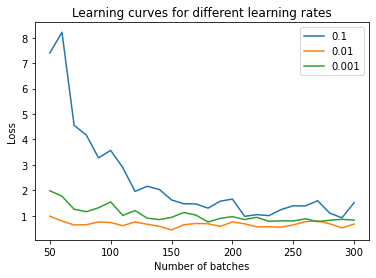

In [56]:
learning_curves.loc[50:, [0.1, 0.01, 0.001]].plot()
plt.title('Learning curves for different learning rates')
plt.xlabel('Number of batches')
plt.ylabel('Loss')
plt.show()

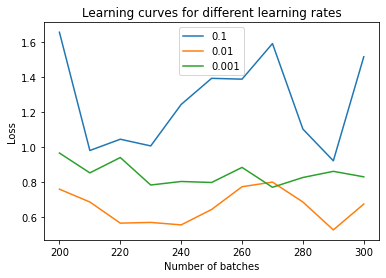

In [57]:
learning_curves.loc[200:, [0.1, 0.01, 0.001]].plot()
plt.title('Learning curves for different learning rates')
plt.xlabel('Number of batches')
plt.ylabel('Loss')
plt.show()

A learning rate of 0.01 (orange curve) seems the best.

In [58]:
lr = 0.01

# Training the model

In [59]:
df_val_small = df_val.sample(300, random_state=123)

In [60]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader_small = create_data_loader(df_val_small, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [61]:
model = SentimentRegressor()
model.to(device)

SentimentRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [62]:
optimizer = Adam(model.parameters(), lr)

In [63]:
def train_epoch(model, data_loader, loss_criterion, optimizer, device, scheduler):
    model = model.train()
    
    losses = []
    
    for i, data in enumerate(data_loader, 0):
        if i % 1000 == 999:
            print(f'Batch {i + 1}')
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)
        
        loss = train_batch(model, data, loss_criterion, optimizer, device, scheduler)
        
        if i % 10 == 9: 
            average_loss_last_10_batches = np.mean(temp_losses)
            temp_losses = []
            losses[lr].append(average_loss_last_10_batches)
            print(average_loss_last_10_batches)
        losses.append(loss.item())
        
    return losses

In [64]:
def eval_model(model, data_loader, loss_criterion, device):
    model = model.eval()
    
    losses = []
    
    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = loss_criterion(outputs, targets)
            
            losses.append(loss.item())
    return np.mean(losses)

In [65]:
%%time

EPOCHS = 1
history = defaultdict(list)

for epoch in range(EPOCHS): # loop over the epochs
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    model = model.train()
    
    temp_losses = []
    for i, data in enumerate(train_data_loader, 0): # loop over the mini batches
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        loss = train_batch(model, data, criterion, optimizer, device)
        temp_losses.append(loss.item())
        
        if i % 100 == 99: # save the average loss every 100 minibatches
            average_loss_last_100_batches = np.mean(temp_losses)
            temp_losses = []
            history['train_loss'].append(average_loss_last_100_batches)
            
        if i % 100 == 99: # evaluate the model on the validation set every 1000 minibatches
            print(f'Train loss {average_loss_last_100_batches}')
            val_loss = eval_model(model, val_data_loader_small, criterion, device)
            history['val_loss'].append(val_loss)
            print(f'Val loss {val_loss}')
            print()
            model = model.train()
        
        if i == 3000:
            break
            

Epoch 1/1
----------
Train loss 3.6919410663843153
Val loss 0.3056415452768928

Train loss 0.6130914098024368
Val loss 0.31293480960946335

Train loss 0.669000578224659
Val loss 0.2753954302323492

Train loss 0.6871244961023331
Val loss 0.47425738918153865

Train loss 0.6257244470715523
Val loss 0.46481821097825704

Train loss 0.5604108484089374
Val loss 0.36109981803517593

Train loss 0.593799295425415
Val loss 0.2683764507896022

Train loss 0.6900050941109658
Val loss 0.2943790060909171

Train loss 0.7381497743725777
Val loss 0.5567974134495384

Train loss 0.7292127877473831
Val loss 0.3188767041030683

Train loss 0.704923359155655
Val loss 0.6475215648349962

Train loss 0.6389334982633591
Val loss 0.8081659078598022

Train loss 0.6417611055076122
Val loss 0.39337649157172755

Train loss 0.7672584134340287
Val loss 0.3909196234063098

Train loss 0.7346857152879238
Val loss 0.3817003055622703

Train loss 0.8140191812813282
Val loss 0.8884395235463193

Train loss 0.7796403130888939
Val

In [66]:
# MSE on the full validation set
val_loss = eval_model(model, val_data_loader_small, criterion, device)
print(val_loss)

0.2813246971682498


# Let's try out some predictions

In [67]:
positive_review = 'The breakfast was yummy. The personel was lovely and I slept like a baby!'
negative_review = 'The bathroom could use some modernization.'
review = ' '.join([positive_review, tokenizer.sep_token, negative_review])

encoding = tokenizer(review, 
                     max_length=MAX_LEN,
                     return_tensors='pt',
                     padding='max_length',
                     truncation=True)

In [68]:
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

model(input_ids, attention_mask)

tensor([[8.9737]], device='cuda:0', grad_fn=<AddmmBackward>)